Constants

In [ ]:
TEST_DAYS             = 252       # How long the final forecast will be
WINDOW                = 63        # 1 month of history = 21; 1 year of history = 252
HORIZON               = 21        # Forcasting horizon split size

size_layer            = 128       # hidden_size
num_layers            = 3         # number of layers
dropout_rate          = 0.1       # 0.1 to 0.3
epoch                 = 400       # training iterations
learning_rate         = 1e-3      # 3e-3 to 1e-4
weight_decay          = 1e-5      # 1e-2 to 1e-5 
min_lr                = 1e-8      # lr will reduce to this value slowly
batch_size            = 128       # based on Vram
max_norm              = 5         # 1 (potentially slow training), 5 or 10 (potentially instable)
teacher_forcing_ratio = 0.7       # 0.1 (harder to train) to 1 (exposer bias)

Data Loading

In [2]:
import torch
from sklearn.preprocessing import StandardScaler
from data_loader import create_df, make_windows

features = ["Open", "High", "Low", "Close"]
df = create_df("MSFT")

data = df[features].values
data_len = len(data)

# index where test period starts (raw data index)
test_start = data_len - (TEST_DAYS + WINDOW)

train_raw = data[:test_start]
test_raw  = data[test_start:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled = scaler.transform(test_raw)

X_train, Y_train = make_windows(train_scaled, WINDOW, HORIZON)
X_test,  Y_test  = make_windows(test_scaled,  WINDOW, HORIZON)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

print(len(X_train_t))
print(len(X_train_t[0]))
print(len(X_test_t))
print(len(X_test_t[0]))
print()
print(len(Y_train_t))
print(len(Y_train_t[0]))
print(len(Y_test_t))
print(len(Y_test_t[0]))



2117
63
232
63

2117
21
232
21


Model Training

In [4]:
import LSTM_model as M
from training_helpers import train_model

input_size = X_train_t.shape[2]
output_size = X_train_t.shape[2]

model = M.Seq2SeqLSTM(
    input_size=input_size,
    hidden_size=size_layer,
    num_layers=num_layers,
    horizon=HORIZON,
    output_size=output_size,
    dropout=dropout_rate,
)

# Train
train_model(
    model,
    X_train_t,
    Y_train_t,
    epochs=epoch,
    lr=learning_rate,
    weight_decay=weight_decay,
    min_lr=min_lr,
    batch_size=batch_size,
    max_norm=max_norm,
    init_ratio=teacher_forcing_ratio
)

Epoch 1/400 | Total Loss: 19.292858 | Avg Loss: 1.134874 | LR: 1.00e-03
Epoch 2/400 | Total Loss: 8.884097 | Avg Loss: 0.522594 | LR: 1.00e-03
Epoch 3/400 | Total Loss: 13.409415 | Avg Loss: 0.788789 | LR: 1.00e-03
Epoch 4/400 | Total Loss: 5.606104 | Avg Loss: 0.329771 | LR: 1.00e-03
Epoch 5/400 | Total Loss: 7.959418 | Avg Loss: 0.468201 | LR: 1.00e-03
Epoch 6/400 | Total Loss: 5.066540 | Avg Loss: 0.298032 | LR: 1.00e-03
Epoch 7/400 | Total Loss: 4.554856 | Avg Loss: 0.267933 | LR: 1.00e-03
Epoch 8/400 | Total Loss: 3.391053 | Avg Loss: 0.199474 | LR: 1.00e-03
Epoch 9/400 | Total Loss: 2.899704 | Avg Loss: 0.170571 | LR: 1.00e-03
Epoch 10/400 | Total Loss: 2.943351 | Avg Loss: 0.173138 | LR: 1.00e-03
Epoch 11/400 | Total Loss: 2.243197 | Avg Loss: 0.131953 | LR: 1.00e-03
Epoch 12/400 | Total Loss: 2.320311 | Avg Loss: 0.136489 | LR: 1.00e-03
Epoch 13/400 | Total Loss: 3.066690 | Avg Loss: 0.180394 | LR: 1.00e-03
Epoch 14/400 | Total Loss: 1.401079 | Avg Loss: 0.082416 | LR: 1.00e-03

Model Testing

X_test shape: torch.Size([232, 63, 4])
X_test ndim: 3
RMSE (Close): 102.2322
MAE (Close): 99.4675
Directional Accuracy: 0.514


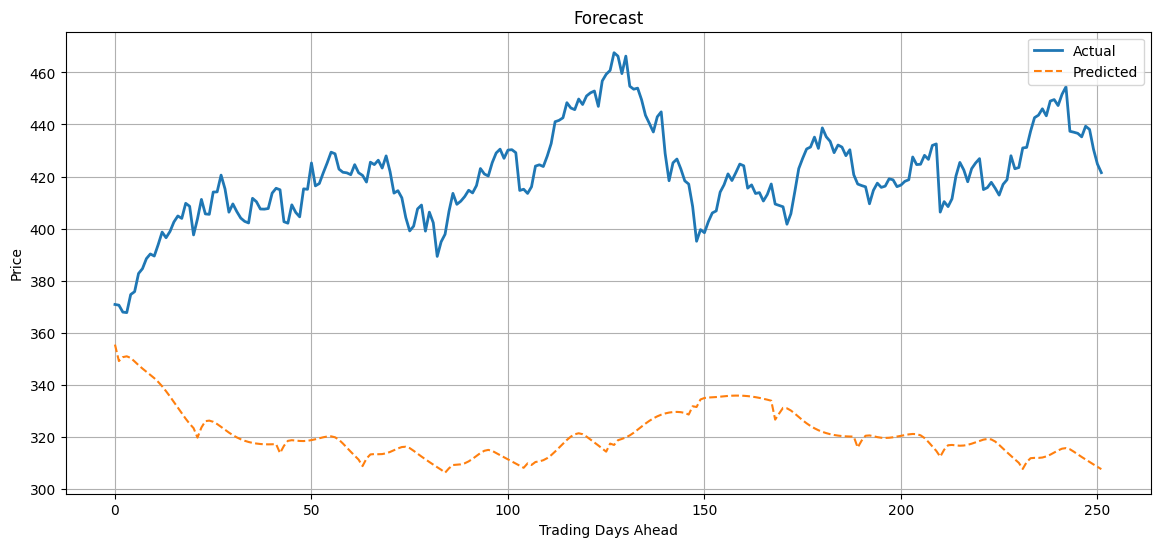

In [5]:
from testing_helpers import test_long_horizon, stats, plot

preds = test_long_horizon(
    model, X_test_t, scaler, TEST_DAYS, HORIZON
)

true = df[features].values[-TEST_DAYS:]

stats(true, preds)
plot(true, preds)